![image info](https://ineuron.ai/images/ineuron-logo.png)

# Data Pre-Processing

#### Import Packages and CSV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)
# Create Dataframe
df = pd.read_csv("data/Travel.csv")

# Print shape of dataset
print(df.shape)

(4888, 20)


## Data Cleaning

#### Check Spelling mistake

In [2]:
df["Gender"] = df["Gender"].replace("Fe Male", "Female")

#### Check Null Values

In [3]:
##these are the features with nan value
features_with_na = [
    features for features in df.columns if df[features].isnull().sum() >= 1
]
for feature in features_with_na:
    print(feature, np.round(df[feature].isnull().mean() * 100, 5), "% missing values")

Age 4.62357 % missing values
TypeofContact 0.51146 % missing values
DurationOfPitch 5.13502 % missing values
NumberOfFollowups 0.92062 % missing values
PreferredPropertyStar 0.53191 % missing values
NumberOfTrips 2.86416 % missing values
NumberOfChildrenVisiting 1.35025 % missing values
MonthlyIncome 4.76678 % missing values


**What does NaN mean?**

**Ans:** Missing Values in a DataFrame

**Why might a value be missing?** 

**Ans:** When considering the potential impact of the missing data on the Dataset, it is important to consider the underlying reasons for why the data are missing
Missing data are of three categories:
* Missing completely at random (MCAR)
* Missing at random (MAR).
* Missing not at random (MNAR). 

Here it is MCAR type of missing values in dataset which are Missing completely at Random. 

When we make this assumption, we are assuming the missing data is completely unrelated to the other information in the data.

In [4]:
# statistics on numerical columns (Null cols)
df[features_with_na].select_dtypes(exclude="object").describe()

,Age,DurationOfPitch,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,NumberOfChildrenVisiting,MonthlyIncome
count,4662.000000,4637.000000,4843.000000,4862.000000,4748.000000,4822.000000,4655.000000
mean,37.622265,15.490835,3.708445,3.581037,3.236521,1.187267,23619.853491
std,9.316387,8.519643,1.002509,0.798009,1.849019,0.857861,5380.698361
min,18.000000,5.000000,1.000000,3.000000,1.000000,0.000000,1000.000000
25%,31.000000,9.000000,3.000000,3.000000,2.000000,1.000000,20346.000000
50%,36.000000,13.000000,4.000000,3.000000,3.000000,1.000000,22347.000000
75%,44.000000,20.000000,4.000000,4.000000,4.000000,2.000000,25571.000000
max,61.000000,127.000000,6.000000,5.000000,22.000000,3.000000,98678.000000


### 3.2 Other Data Cleaning steps

**Handling Duplicates**

In [5]:
df.duplicated().sum()

0

**Remove Customer ID from the dataset as it cannot used in Model Training**

In [6]:
df.drop("CustomerID", inplace=True, axis=1)

# Feature Engineering

### Type of Features

**Numeric Features**

In [7]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != "O"]
print("Num of Numerical Features :", len(numeric_features))

Num of Numerical Features : 13


**Categorical Features**

In [8]:
categorical_features = [feature for feature in df.columns if df[feature].dtype == "O"]
print("Num of Categorical Features :", len(categorical_features))

Num of Categorical Features : 6


**Discrete Features**

In [9]:
discrete_features = [
    feature for feature in numeric_features if (len(df[feature].unique()) <= 25)
]
print("Num of Discrete Features :", len(discrete_features))

Num of Discrete Features : 10


**Continuous features**

In [10]:
continuous_features = [
    feature for feature in numeric_features if len(df[feature].unique()) > 25
]
print("Num of Continuous Features :", len(continuous_features))

Num of Continuous Features : 3


**Imputing Null Values to Check VIF(Multi-Collinearity)**

In [11]:
df1 = df.copy()
for i in continuous_features:
    df1[i].fillna(df1[i].median(), inplace=True)

### Multicollinearity Check
#### Variance Inflation Factor (VIF)

* Multicollinearity occurs when there are two or more independent variables in a multiple regression model, which have a high correlation among themselves. When some features are highly correlated.
* Multicollinearity can be detected using various techniques, one such technique being the Variance Inflation Factor(VIF).

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


def compute_vif(considered_features, df):

    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X["intercept"] = 1

    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif["Variable"] != "intercept"]
    return vif

In [13]:
compute_vif(continuous_features, df1)

,Variable,VIF
0,Age,1.270393
1,DurationOfPitch,1.000089
2,MonthlyIncome,1.270357


 ” VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable “ 

VIF above 5 is indicator of MultiCollinearity  
 
**- This Dataset Doesnt have any MultiCollinearity**

### Check Outlier and Capping it

**Why outliers?**
* Data Entry error : Human error. 
* Measurement error: Instrument error. 
* Natural error: it will be Real life data.
* Intentional error: People give wrong inputs

**Impact of Outliers ?**
* Ouliers can very high impact on few Machine learning models.
* Can Cause bias in the output.

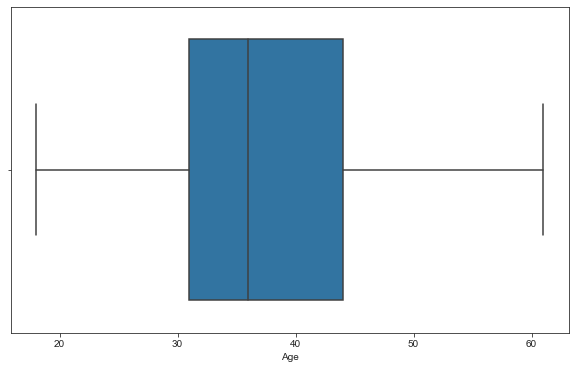

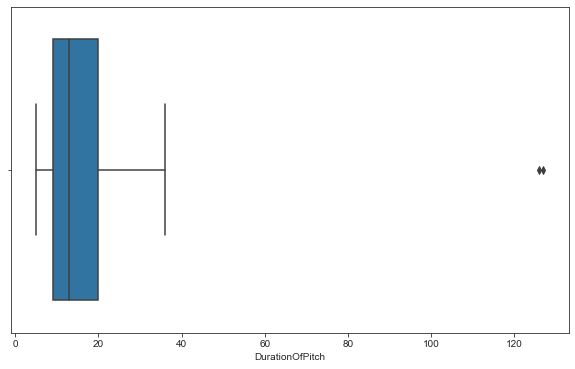

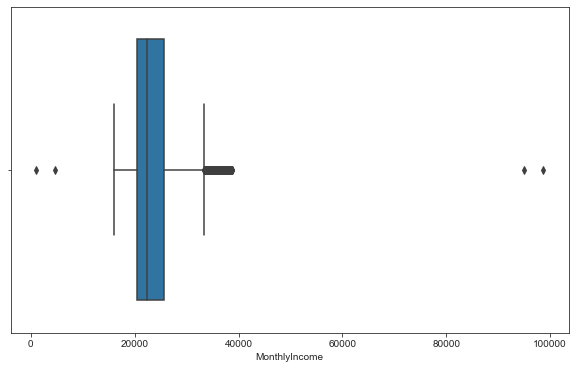

In [14]:
for i in continuous_features:
    plt.figure(figsize=(10, 6))
    sns.set_style("ticks")
    ax = sns.boxplot(df[i])

**Why Z score For Outlier Handling?**

In [15]:
def outlier_removal(column, df):
    upper_limit = df[column].mean() + 3 * df[column].std()
    lower_limit = df[column].mean() - 3 * df[column].std()
    df = df[(df[column] < upper_limit) & (df[column] > lower_limit)]
    return df

In [16]:
df.shape

(4888, 19)

In [17]:
outlier_feature = ["DurationOfPitch", "MonthlyIncome"]

In [18]:
for i in range(len(outlier_feature)):
    df1 = outlier_removal(outlier_feature[i], df1)

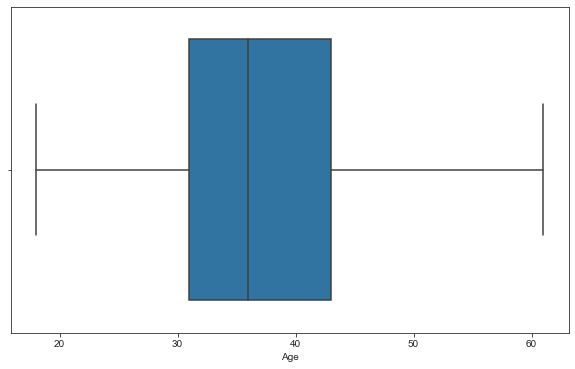

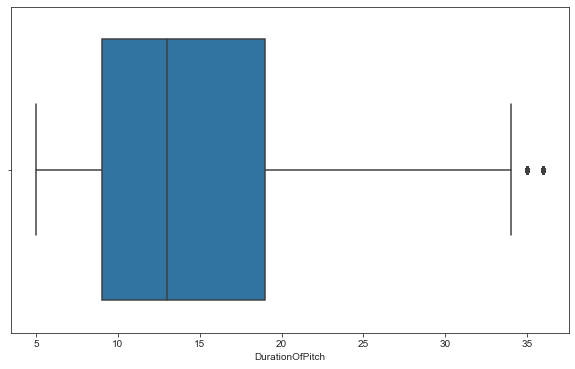

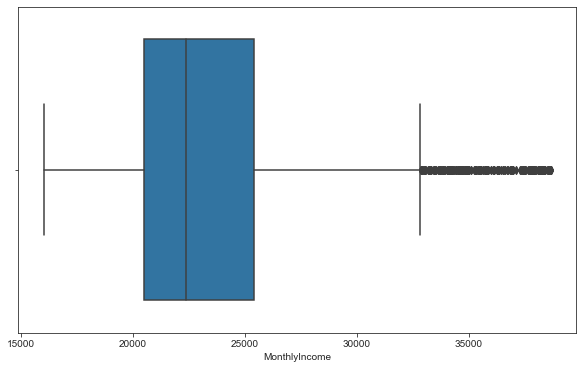

In [19]:
for i in continuous_features:
    plt.figure(figsize=(10, 6))
    sns.set_style("ticks")
    ax = sns.boxplot(df1[i])

## Feature Transformation

In [20]:
df[continuous_features].skew(axis=0)

Age                0.382989
DurationOfPitch    1.752037
MonthlyIncome      1.949160
dtype: float64

* **If Skewness is above 2 then the feature is Highly skewed**
* **If Skewness is above 1.5 then the feature is Moderately skewed**

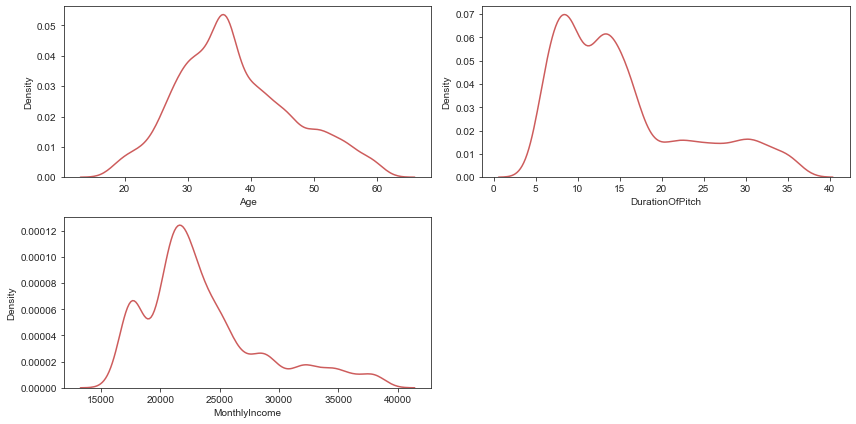

In [21]:
# distribution of data before scaling
plt.figure(figsize=(12, 6))
for i, col in enumerate(["Age", "DurationOfPitch", "MonthlyIncome"]):
    plt.subplot(2, 2, i + 1)
    sns.kdeplot(x=df1[col], color="indianred")
    plt.xlabel(col)
    plt.tight_layout()

- **Here Monthly income and DurationOfPitch are skewed**
- **Age is normally distributed**

### Split X and Y

In [22]:
from sklearn.model_selection import train_test_split

X = df.drop(["ProdTaken"], axis=1)
y = df["ProdTaken"]

* **Split Dataframe to X and y**
* **Here we set a variable X i.e, independent columns, and a variable y i.e, dependent column as the “ProdTaken” column.**


In [23]:
for feature in categorical_features:
    print(feature, ":", X[feature].nunique())

TypeofContact : 2
Occupation : 4
Gender : 2
ProductPitched : 5
MaritalStatus : 4
Designation : 5


## Feature Encoding and Scaling

 **One Hot Encoding for Columns which had lesser unique values and not ordinal**
* One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

In [24]:
for i in continuous_features:
    print(f"{i}: mean = {df[i].mean():.2f}, median = {df[i].median():.2f}")

Age: mean = 37.62, median = 36.00
DurationOfPitch: mean = 15.49, median = 13.00
MonthlyIncome: mean = 23619.85, median = 22347.00


* **Mean imputer:**
 - It replaces the missing value with the mean of the respected features excluding null values.
 - Since we handeled outlier for the continuous features the mean and median of the features are nearly same. When there are no outliers mean performs an a better imputer.
* **Mode imputer:**
 - It replaces the missing values with the mode/most frequent/most repeated values.
 - For discrete features we use mode as imputer.
* **Standardscaler:**
 - It is a scaling technique based on the standard normal distribution. which uses $ \frac{(x - \mu)} {\sigma} $ to scale. it scales down such that all the data points will lied between $ 3 \sigma $ of the features distribution. It performes well when the data is normally distributed.
 - As the features distribution are nearly normal we use standard scaler.
* **Power Transformer:**
 - It is applied to make data more like a guassian distribution.
 - Since Monthly income and DurationOfPitch are skewed we use Power Transformer on them

In [25]:
# Create Column Transformer with 3 types of transformers
cat_features = X.select_dtypes(include="object").columns
disc_feature = discrete_features.copy()
disc_feature.remove("ProdTaken")
transform_features = ["MonthlyIncome", "DurationOfPitch"]


from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

discrete_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("scaler", StandardScaler()),
    ]
)

continuous_pipeline = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

cat_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("one_hot_encoder", OneHotEncoder()),
        ("scaler", StandardScaler(with_mean=False)),
    ]
)

transform_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("transformer", PowerTransformer(standardize=True)),
    ]
)

preprocessor = ColumnTransformer(
    [
        ("Discrete_Pipeline", discrete_pipeline, disc_feature),
        ("Continuous_Pipeline", continuous_pipeline, continuous_features),
        ("Categorical_Pipeline", cat_pipeline, cat_features),
        ("Power_Transformation", transform_pipe, transform_features),
    ]
)

In [26]:
X.shape

(4888, 18)

In [27]:
X = preprocessor.fit_transform(X)

## Handling Imbalanced Dataset

* Handling Imbalanced Target Variable.
* Synthetic Minority Oversampling Technique or SMOTE is another technique to oversample the minority class. Simply adding duplicate records of minority class often don’t add any new information to the model.

* SMOTE is one of the famous oversampling techniques and is very effective in handling class imbalance. The idea is to combine SMOTE with some undersampling techniques (ENN, Tomek) to increase the effectiveness of handling the imbalanced class.

In [28]:
from imblearn.combine import SMOTETomek

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42, sampling_strategy="minority")
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X, y)

## Model Selection
* **Here should understand the Various Classification models with default values from these models we can choose top 4 with Highest Accuracy score and proceed with HyperParameter Tuning**

## Train Test Split

* The train-test split procedure is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model.

* It is a fast and easy procedure to perform, the results of which allow you to compare the performance of machine learning algorithms.

**Import Required packages for model training**

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [34]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted)  # Calculate Accuracy
    f1 = f1_score(true, predicted)  # Calculate F1-score
    precision = precision_score(true, predicted)  # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted)  # Calculate Roc
    return acc, f1, precision, recall, roc_auc

In [35]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(),
    "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    #      "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier(),
}

In [36]:
# Create a function which can evaluate models and return a report
def evaluate_models(X, y, models):
    """
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    """
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    models_list = []
    accuracy_list = []

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train)  # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        (
            model_train_accuracy,
            model_train_f1,
            model_train_precision,
            model_train_recall,
            model_train_rocauc_score,
        ) = evaluate_clf(y_train, y_train_pred)

        # Test set performance
        (
            model_test_accuracy,
            model_test_f1,
            model_test_precision,
            model_test_recall,
            model_test_rocauc_score,
        ) = evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print("Model performance for Training set")
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print("- F1 score: {:.4f}".format(model_train_f1))
        print("- Precision: {:.4f}".format(model_train_precision))
        print("- Recall: {:.4f}".format(model_train_recall))
        print("- Roc Auc Score: {:.4f}".format(model_train_rocauc_score))

        print("----------------------------------")

        print("Model performance for Test set")
        print("- Accuracy: {:.4f}".format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print("- F1 score: {:.4f}".format(model_test_f1))
        print("- Precision: {:.4f}".format(model_test_precision))
        print("- Recall: {:.4f}".format(model_test_recall))
        print("- Roc Auc Score: {:.4f}".format(model_test_rocauc_score))
        print("=" * 35)
        print("\n")

    report = pd.DataFrame(
        list(zip(models_list, accuracy_list)), columns=["Model Name", "Accuracy"]
    ).sort_values(by=["Accuracy"], ascending=False)

    return report

## Evaluate all base Models

In [37]:
base_report = evaluate_models(X=X_res, y=y_res, models=models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9679
- F1 score: 0.9674
- Precision: 0.9631
- Recall: 0.9717
- Roc Auc Score: 0.9680


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9332
- F1 score: 0.9324
- Precision: 0.9253
- Recall: 0.9396
- Roc Auc Score: 0.9334


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9176
- F1 score: 0.9150
- Precision: 0.9501
- Recall: 0.8824
- Roc Auc Score: 0.9178
----------------------------------
Model performance for Test set
- Accuracy: 0.8999
- F1 score: 0.8942
- Precision: 0.9269
- Recall: 0.8638
- Roc Auc Score: 0.8992


Logistic Regression
Model performance for Training 

In [38]:
base_report

,Model Name,Accuracy
0,Random Forest,0.967884
5,XGBClassifier,0.955290
6,CatBoosting Classifier,0.945214
1,Decision Tree,0.933249
2,Gradient Boosting,0.899874
4,K-Neighbors Classifier,0.899874
7,AdaBoost Classifier,0.857053
3,Logistic Regression,0.748741


**Here we can use Random Forest , XGBoost Classifier, CatBoost Classifier for Hyper Parameter Tuning as they preform well with the base parameters.**

In [39]:
# Initialize few parameter for Hyperparamter tuning
rf_params = {
    "max_depth": [5, 8, 15, None, 10],
    "max_features": [5, 7, "auto", 8],
    "min_samples_split": [2, 8, 15, 20],
    "n_estimators": [100, 200, 500, 1000],
}

xgboost_params = {
    "learning_rate": [0.1, 0.01],
    "max_depth": [5, 8, 12, 20, 30],
    "n_estimators": [100, 200, 300],
    "colsample_bytree": [0.5, 0.8, 1, 0.3, 0.4],
}

cat_params = {"learning_rate": [0.1, 0.01], "max_depth": [5, 8, 12, 20, 30]}

In [40]:
# Models list for Hyperparameter tuning
randomcv_models = [
    ("RF", RandomForestClassifier(), rf_params),
    ("XGBoost", XGBClassifier(), xgboost_params),
    ("CatBoost", CatBoostClassifier(verbose=False), cat_params),
]

**We can use RandomizedSearchCV to do the hyperparametric tuning which chooses the random combination of the different parameters and fits the model. It is used to reduce the computation since fitting to all the combinations of hyperparameters take longer and used high computation power.**

In [41]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=100,
        cv=3,
        verbose=2,
        n_jobs=-1,
    )
    random.fit(X_res, y_res)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
---------------- Best Params for RF -------------------
{'n_estimators': 1000, 'min_samples_split': 2, 'max_features': 5, 'max_depth': None}
---------------- Best Params for XGBoost -------------------
{'n_estimators': 300, 'max_depth': 30, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
---------------- Best Params for CatBoost -------------------
{'max_depth': 12, 'learning_rate': 0.01}


**Above we can see the best parameters selected for models. It may change when you train because of the random selcetion of parameters by RandomizedSearchCV. But there will ot be much change in the metrics of the models.**

### Retraining the Model with best Parameters

* We can retrain the models with the best parameters selected by the RandomizedSearchCV and check other metrics of the selected models

In [44]:
from sklearn.metrics import roc_auc_score, roc_curve

best_models = {
    "Random Forest": RandomForestClassifier(**model_param["RF"]),
    "XGBClassifier": XGBClassifier(**model_param["XGBoost"], n_jobs=-1),
    "CatBoosting Classifier": CatBoostClassifier(
        **model_param["CatBoost"], verbose=False
    ),
}
tuned_report = evaluate_models(X=X_res, y=y_res, models=best_models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9698
- F1 score: 0.9692
- Precision: 0.9668
- Recall: 0.9717
- Roc Auc Score: 0.9698


XGBClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9717
- F1 score: 0.9711
- Precision: 0.9717
- Recall: 0.9704
- Roc Auc Score: 0.9716


CatBoosting Classifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9868
- F1 score: 0.9866
- Precision: 0.9809
- Recall: 0.9923
- Roc Auc Score: 0.9869




In [45]:
tuned_report

,Model Name,Accuracy
2,CatBoosting Classifier,0.986776
1,XGBClassifier,0.971662
0,Random Forest,0.969773


## Plot Roc Auc Curve

**Now lets check the area under curve(AUC) of receiver operating characteristic(ROC) curve to justify the accuracy we have seen the the selected models.**

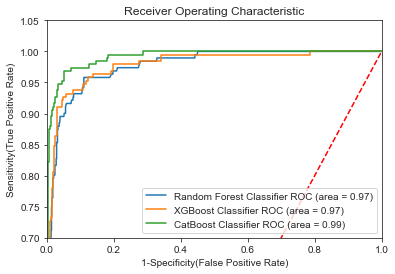

In [50]:
from sklearn.metrics import roc_auc_score, roc_curve

plt.figure()

# Add the models to the list that you want to view on the ROC plot
auc_models = [
    {
        "label": "Random Forest Classifier",
        "model": RandomForestClassifier(
            n_estimators=1000, min_samples_split=2, max_features=5, max_depth=None
        ),
        "auc": 0.9698,
    },
    {
        "label": "XGBoost Classifier",
        "model": XGBClassifier(
            n_estimators=300,
            max_depth=30,
            learning_rate=0.1,
            colsample_bytree=0.8,
            n_jobs=-1,
        ),
        "auc": 0.9716,
    },
    {
        "label": "CatBoost Classifier",
        "model": CatBoostClassifier(max_depth=12, learning_rate=0.01, verbose=False),
        "auc": 0.9869,
    },
]
# create loop through all model
for algo in auc_models:
    model = algo["model"]  # select the model
    model.fit(X_train, y_train)  # train the model
    # Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    # Calculate Area under the curve to display on the plot
    plt.plot(fpr, tpr, label="%s ROC (area = %0.2f)" % (algo["label"], algo["auc"]))
# Custom settings for the plot
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.7, 1.05])
plt.xlabel("1-Specificity(False Positive Rate)")
plt.ylabel("Sensitivity(True Positive Rate)")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
# plt.savefig(r"./images/auc.png")
plt.show()  # Display

### As Models have very high accuracy we can use cross validation score for further evaluation.

Cross-validation is a statistical method used to estimate the accuracy of machine learning models. It is used to protect against overfitting in a predictive model, particularly in a case where the amount of data may be limited.

Stratified kfold cross validation is an extension of regular kfold cross validation but specifically for classification problems where rather than the splits being completely random, the ratio between the target classes is the same in each fold as it is in the full dataset. Which preserves the distribution of target column in both train and test data.

**Stratified K-fold Cross Validation Technique on 3 algorithm to know the exact Mean CV accuracy score**

In [51]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [57]:
cat_cv_result = cross_val_score(
    CatBoostClassifier(**model_param["CatBoost"], verbose=False),
    X_test,
    y_test,
    cv=skfold,
    scoring="accuracy",
    n_jobs=-1,
)
cat_cv = cat_cv_result.mean() * 100
print("CatBoost CV Mean Accuarcy Score is {}".format(cat_cv))

CatBoost CV Mean Accuarcy Score is 86.29497159688617


In [56]:
xgb_cv_result = cross_val_score(
    XGBClassifier(**model_param["XGBoost"]),
    X_test,
    y_test,
    cv=skfold,
    scoring="accuracy",
    n_jobs=-1,
)
xgb_cv = xgb_cv_result.mean() * 100
print("XGB Classifier CV Mean Accuarcy Score is {}".format(xgb_cv))

XGB Classifier CV Mean Accuarcy Score is 86.08773406269722


In [55]:
rf_cv_result = cross_val_score(
    RandomForestClassifier(**model_param["RF"]),
    X_test,
    y_test,
    cv=skfold,
    scoring="accuracy",
    n_jobs=-1,
)
rf_cv = rf_cv_result.mean() * 100
print("Random Forest Classifier CV Mean Accuarcy Score is {}".format(rf_cv))

Random Forest Classifier CV Mean Accuarcy Score is 85.17252261729433


| Model Name      | Cross_val_score |
| ----------- | ----------- |
| CatBoosting Classifier   | 86.29%       |
|XGBClassifier   | 86.08%        |
| Random Forest | 85.17%       |

**Even from the cross validation we can see that CatBoost Classifier performs the best with the mentioned parameters. Now we can retrain the model with the best model selected**

In [58]:
best_model = CatBoostClassifier(**model_param["CatBoost"], verbose=False)
best_model = best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print("FINAL MODEL 'CATBOOST'")
print("Accuracy Score value: {:.4f}".format(score))
print(cr)

FINAL MODEL 'CATBOOST'
Accuracy Score value: 0.9489
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       787
           1       0.98      0.75      0.85       191

    accuracy                           0.95       978
   macro avg       0.96      0.88      0.91       978
weighted avg       0.95      0.95      0.95       978



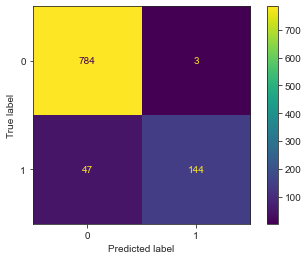

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test);

### Best Model is CatBoost Classifier with 94.89 % Accuracy and also performed well in Cross validation

In [ ]:
import pickle

# Save the trained model as a pickle file.
pickle.dump(best_model, open("holidaypackagemodel.pkl", "wb"))